In [19]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('prices.csv', parse_dates=['begin', 'end'], sep=';')
df.head()

,Unnamed: 0,begin,end,open,high,low,close,value,volume,symbol
0,0,2014-06-09,2014-06-09 23:59:59,15.508,15.508,14.801,15.000,22579.4,1500.0,ABIO
1,1,2014-06-10,2014-06-10 23:59:59,14.871,15.153,14.871,14.881,25469.9,1700.0,ABIO
2,2,2014-06-11,2014-06-11 23:59:59,15.000,15.000,14.999,14.999,2999.9,200.0,ABIO
3,3,2014-06-16,2014-06-16 23:59:59,15.468,15.468,15.000,15.000,24522.3,1600.0,ABIO
4,4,2014-06-17,2014-06-17 23:59:59,15.100,15.120,15.100,15.120,738392.0,48900.0,ABIO


In [16]:
df.dropna(inplace=True)

In [3]:
df.dtypes

,0
Unnamed: 0,int64
begin,datetime64[ns]
end,datetime64[ns]
open,float64
high,float64
low,float64
close,float64
value,float64
volume,float64
symbol,object


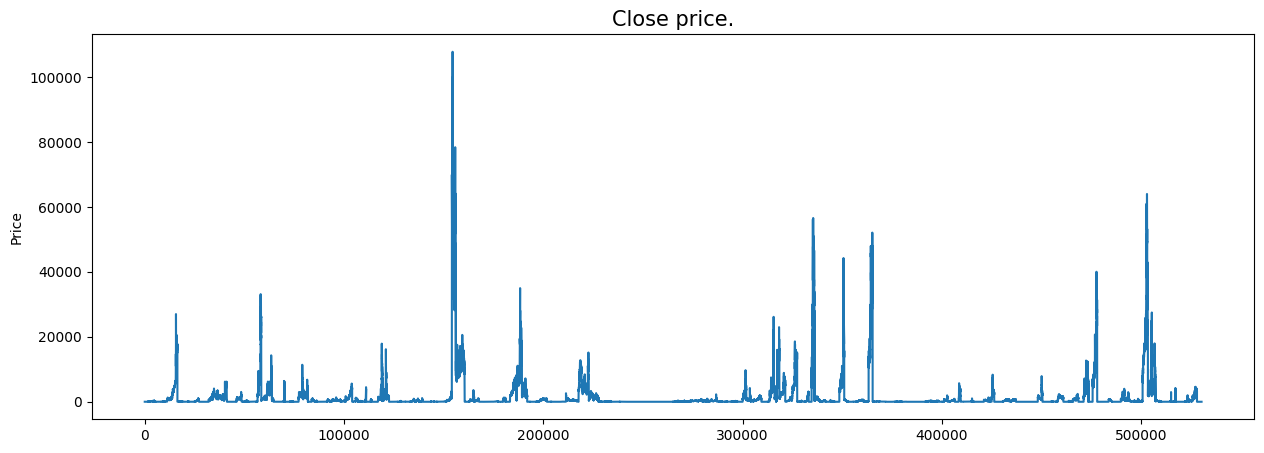

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df['close'])
plt.title('Close price.', fontsize=15)
plt.ylabel('Price')
plt.show()

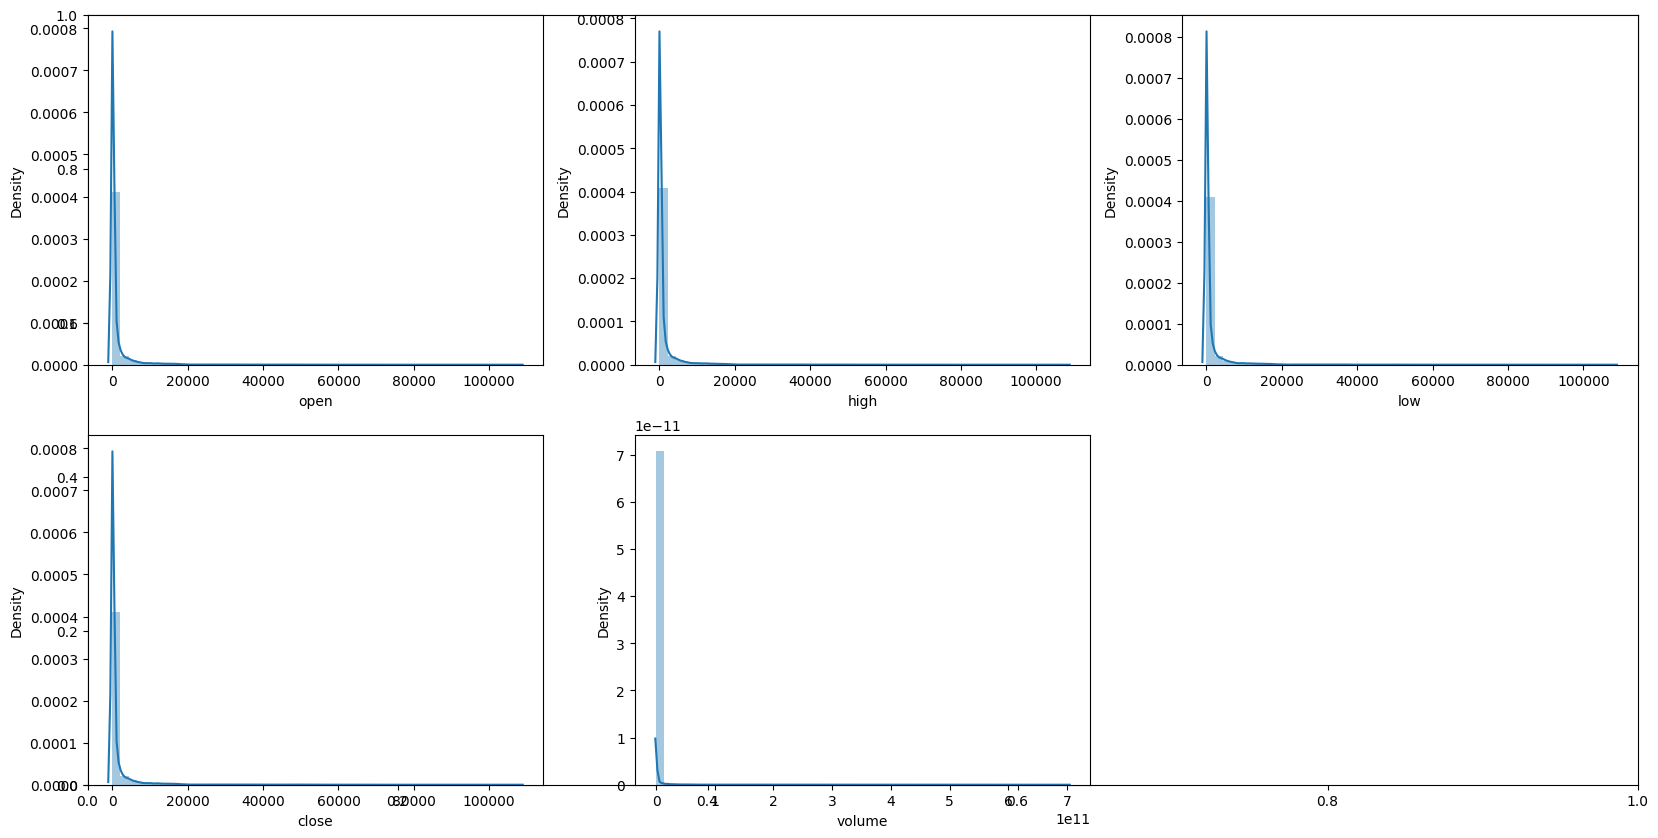

In [6]:
features = ['open', 'high', 'low', 'close', 'volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()

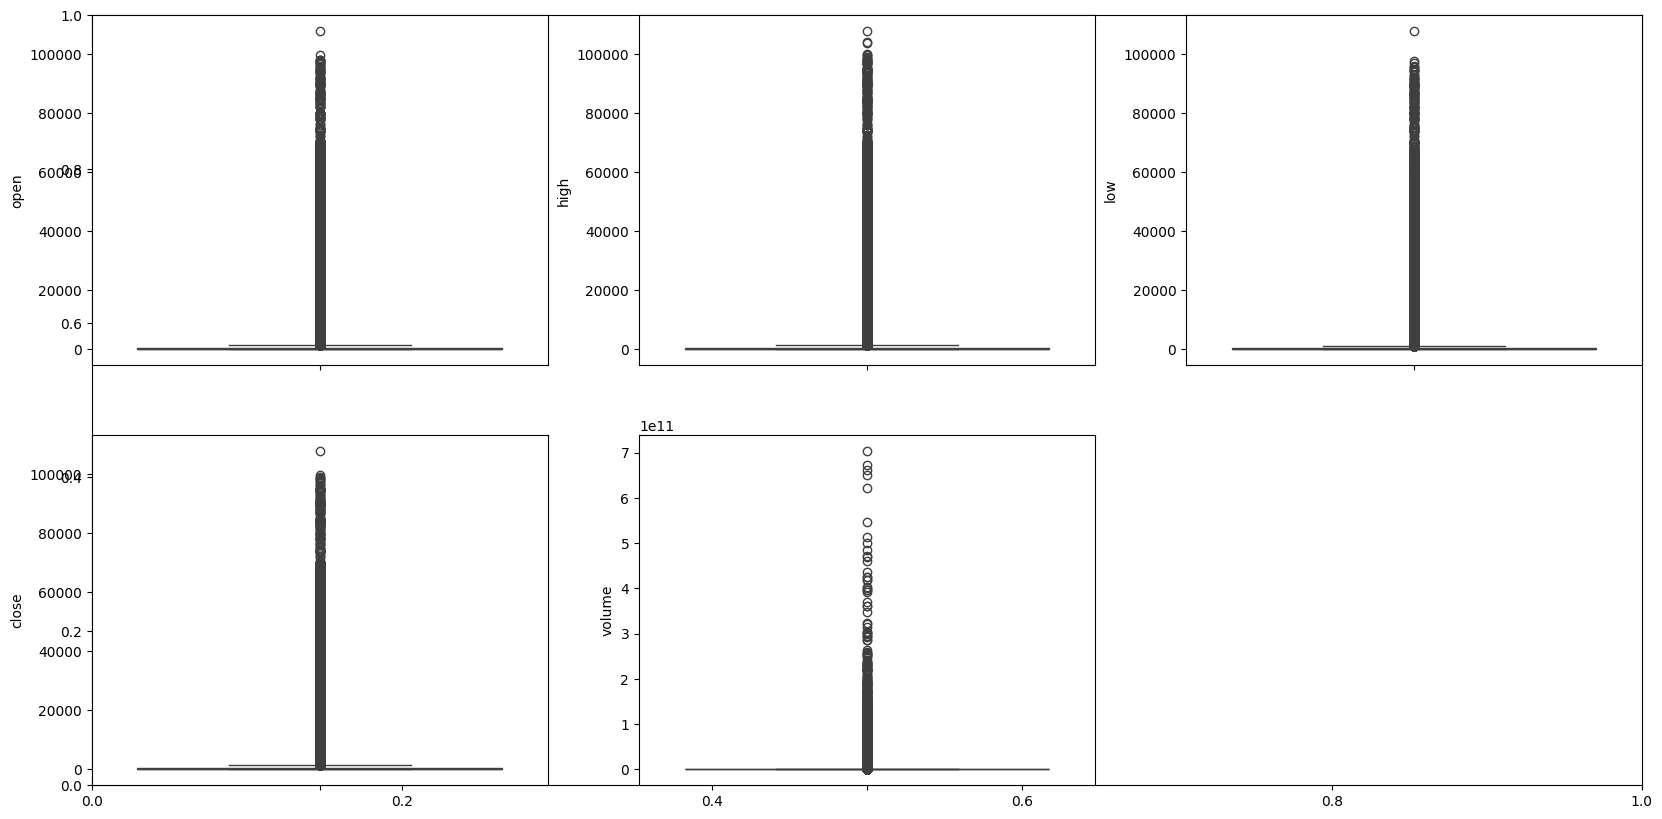

In [7]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [8]:
df['day'] = df['begin'].dt.day
df['month'] = df['begin'].dt.month
df['year'] = df['begin'].dt.year

df.head()

,Unnamed: 0,begin,end,open,high,low,close,value,volume,symbol,day,month,year
0,0,2014-06-09,2014-06-09 23:59:59,15.508,15.508,14.801,15.000,22579.4,1500.0,ABIO,9,6,2014
1,1,2014-06-10,2014-06-10 23:59:59,14.871,15.153,14.871,14.881,25469.9,1700.0,ABIO,10,6,2014
2,2,2014-06-11,2014-06-11 23:59:59,15.000,15.000,14.999,14.999,2999.9,200.0,ABIO,11,6,2014
3,3,2014-06-16,2014-06-16 23:59:59,15.468,15.468,15.000,15.000,24522.3,1600.0,ABIO,16,6,2014
4,4,2014-06-17,2014-06-17 23:59:59,15.100,15.120,15.100,15.120,738392.0,48900.0,ABIO,17,6,2014


In [9]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Unnamed: 0,begin,end,open,high,low,close,value,volume,symbol,day,month,year,is_quarter_end
0,0,2014-06-09,2014-06-09 23:59:59,15.508,15.508,14.801,15.000,22579.4,1500.0,ABIO,9,6,2014,1
1,1,2014-06-10,2014-06-10 23:59:59,14.871,15.153,14.871,14.881,25469.9,1700.0,ABIO,10,6,2014,1
2,2,2014-06-11,2014-06-11 23:59:59,15.000,15.000,14.999,14.999,2999.9,200.0,ABIO,11,6,2014,1
3,3,2014-06-16,2014-06-16 23:59:59,15.468,15.468,15.000,15.000,24522.3,1600.0,ABIO,16,6,2014,1
4,4,2014-06-17,2014-06-17 23:59:59,15.100,15.120,15.100,15.120,738392.0,48900.0,ABIO,17,6,2014,1


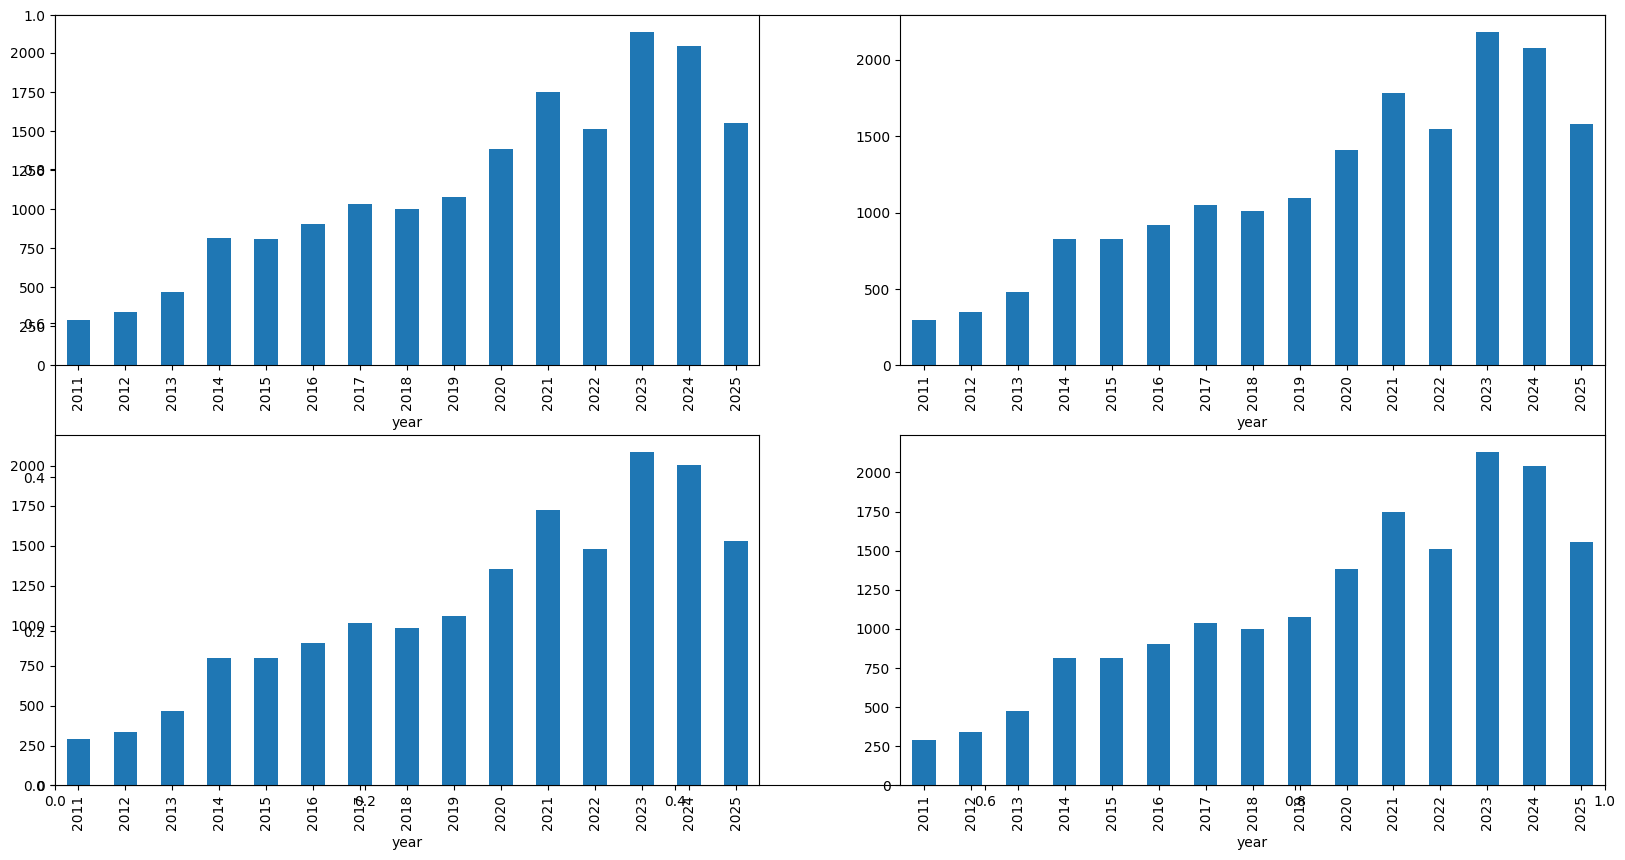

In [10]:
data_grouped = df.drop(columns=['begin','end','symbol'], axis=1).groupby('year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['open', 'high', 'low', 'close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [11]:
df.drop(columns=['begin','end','symbol'], axis=1).groupby('is_quarter_end').mean()

,Unnamed: 0,open,high,low,close,value,volume,day,month,year
is_quarter_end,,,,,,,,,,
0,1223.797453,1389.325080,1415.437379,1365.003748,1388.878969,3.175140e+08,3.531514e+08,16.004258,6.196717,2019.557656
1,1212.272806,1356.300334,1382.593946,1330.603008,1355.659365,3.235026e+08,3.424627e+08,15.901769,7.763210,2019.376304


In [12]:
df['open-close']  = df['open'] - df['close']
df['low-high']  = df['low'] - df['high']
df['target'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)

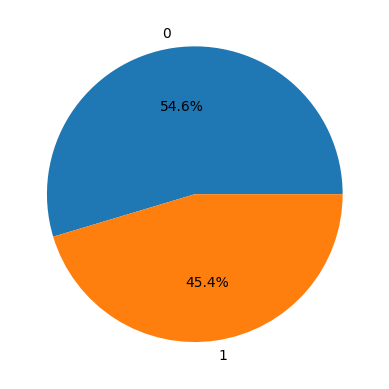

In [13]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

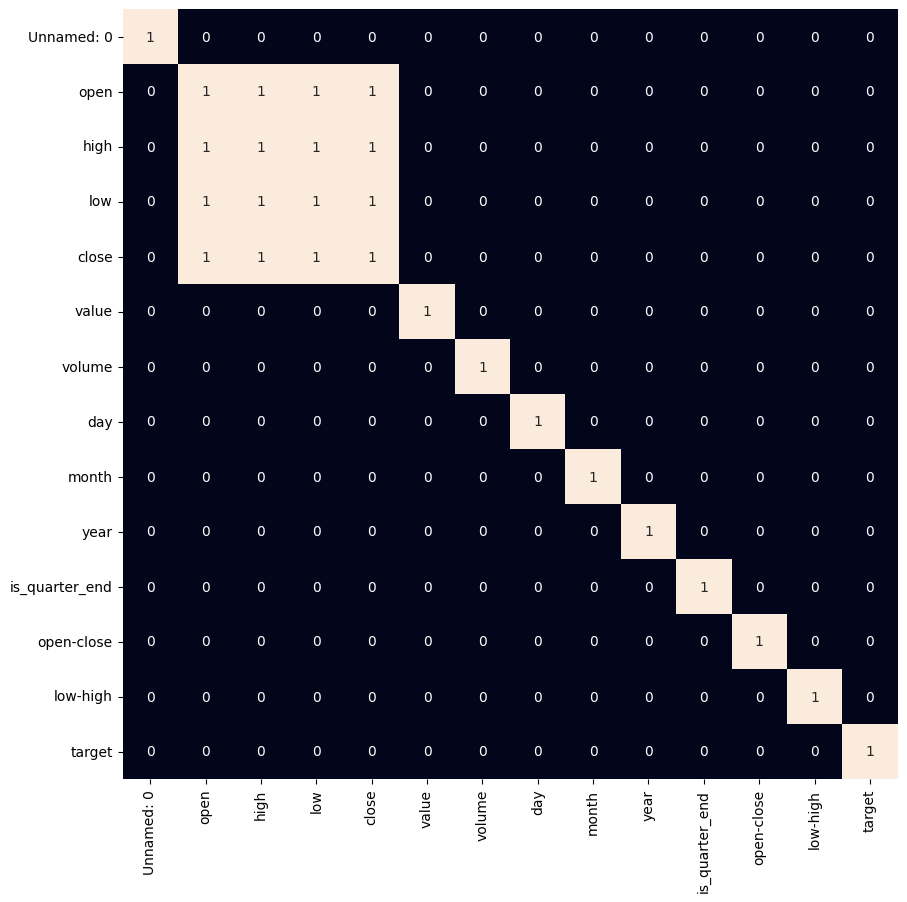

In [14]:
plt.figure(figsize=(10, 10))

sb.heatmap(df.drop(columns=['begin','end','symbol'], axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()


In [15]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(477297, 3) (53034, 3)


In [22]:
models = [LogisticRegression(),  XGBClassifier(), CatBoostClassifier(iterations=2, depth=2, learning_rate=1, loss_function='Logloss', verbose=True)]
#SVC(kernel='poly', probability=True)

for model_ in models:
  model_.fit(X_train, Y_train)

  print(f'{model_} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, model_.predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, model_.predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5156118399801853
Validation Accuracy :  0.5131748284812593

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.5690401322981458
Validation Accuracy :  0.5350141788685921

0:	learn: 0.6875023	total: 47.8ms	remaining: 47.8

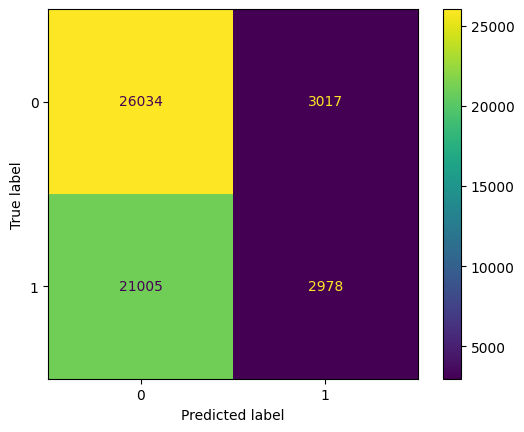

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[1], X_valid, Y_valid)
plt.show()

In [43]:
df['next'] = df['begin'] + pd.DateOffset(1)

In [44]:
df = df.merge(df[['begin','symbol','close']].rename(columns={'close':'next_close'}), how='left',
              left_on=['symbol', 'next'], right_on=['symbol', 'begin'])

In [46]:
df['ch_close'] = df['next_close'] - df['close']

In [49]:
df['target'] = np.where(df['ch_close'] > 0, 1, 0)

In [51]:
df.dropna(inplace=True)

In [52]:
df.head()

,Unnamed: 0,begin_x,end,open,high,low,close,value,volume,symbol,next,begin_y,next_close,ch_close,target
0,0,2014-06-09,2014-06-09 23:59:59,15.508,15.508,14.801,15.000,22579.4,1500.0,ABIO,2014-06-10,2014-06-10,14.881,-0.119,0
1,1,2014-06-10,2014-06-10 23:59:59,14.871,15.153,14.871,14.881,25469.9,1700.0,ABIO,2014-06-11,2014-06-11,14.999,0.118,1
3,3,2014-06-16,2014-06-16 23:59:59,15.468,15.468,15.000,15.000,24522.3,1600.0,ABIO,2014-06-17,2014-06-17,15.120,0.120,1
4,4,2014-06-17,2014-06-17 23:59:59,15.100,15.120,15.100,15.120,738392.0,48900.0,ABIO,2014-06-18,2014-06-18,15.120,0.000,0
5,5,2014-06-18,2014-06-18 23:59:59,14.693,15.120,14.503,15.120,105118.3,7200.0,ABIO,2014-06-19,2014-06-19,14.951,-0.169,0


In [91]:
stock_data = df.copy() # df[df['symbol']=='GAZP']

In [92]:
close_prices = stock_data['close'].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices.reshape(-1, 1))
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [93]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)


seq_length = 60
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [94]:
x_train.shape

(424204, 60, 1)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 817s 81ms/step - loss: 0.2496
Epoch 2/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 806s 81ms/step - loss: 0.2472
Epoch 3/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 812s 81ms/step - loss: 0.2471
Epoch 4/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 804s 80ms/step - loss: 0.2469
Epoch 5/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 854s 80ms/step - loss: 0.2469
Epoch 6/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 807s 80ms/step - loss: 0.2469
Epoch 7/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 803s 80ms/step - loss: 0.2468
Epoch 8/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 801s 80ms/step - loss: 0.2470
Epoch 9/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 806s 81ms/step - loss: 0.2468
Epoch 10/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 807s 81ms/step - loss: 0.2470
Epoch 11/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 862s 81ms/step - loss: 0.2469
Epoch 12/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 860s 81ms/step - loss: 0.2467
Epoch 13/20
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 862s 81ms/step - loss: 0.2465
Epoch 14/20
10003/10003 ━━━━━━━━━━

In [81]:
from joblib import dump, load
model = load('model_lstm.joblib')

In [96]:
predictions = model.predict(x_test)

predictions_scaled = scaler.inverse_transform(predictions)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

3313/3313 ━━━━━━━━━━━━━━━━━━━━ 99s 30ms/step


In [97]:
len(predictions)

106007

In [98]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):], y=y_test_scaled.flatten(), mode='lines', name='Actual Price'))

fig.add_trace(go.Scatter(x=stock_data.index[-len(y_test):], y=predictions_scaled.flatten(), mode='lines', name='Predicted Price'))

fig.update_layout(title='Stock Price Prediction', xaxis_title='Date', yaxis_title='Stock Price')

fig.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

In [64]:
from joblib import dump, load
dump(model, 'model_lstm_2.joblib')
# clf = load('filename.joblib')

['model_lstm_2.joblib']

In [118]:
sp500.begin.min(),sp500.begin.max()

(Timestamp('2014-06-09 00:00:00'), Timestamp('2025-01-13 00:00:00'))

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import math
import random
from datetime import datetime

sp500 = df[df['symbol']=='ABIO']

def normalize(x):
    x = (x - x.min())/(x.max() - x.min())
    return x

def preproc(data):
    data_open = normalize(data['open'].values)
    data_close = normalize(data['close'].values)
    data_high = normalize(data['high'].values)
    data_low = normalize(data['low'].values)
    data_volume = normalize(data['volume'].values)
    data_direction = data_open - data_close
    # Changed for binary classification
    data_direction[data_direction < 0] = 0
    data_direction[data_direction > 0] = 1
    x = np.stack([data_open, data_close, data_high, data_low, data_volume])
    return x, data_direction

class RecurrentNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(RecurrentNet, self).__init__()
        self.layer_1 = torch.nn.LSTM(D_in, H)
        self.hidden_1 = (torch.zeros(1, 1, H), torch.zeros(1, 1, H))
        self.extra_linear_layer = torch.nn.Linear(H,H)
        self.layer_2 = torch.nn.Linear(H,D_out)

    def forward(self, x):
        out, self.hidden_1 = self.layer_1(x, self.hidden_1)
        h_relu = out.clamp(min=0)
        out = self.extra_linear_layer(out)
        h_relu = out.clamp(min=0)
        out = self.layer_2(h_relu)
        y_pred = out
        return y_pred[-1].squeeze()


def create_sequences(x, y, seq_length):
    x_y_sequence = []
    positive_count = 0
    negative_count = 0
    for i in range(len(x) - seq_length):
        seq_x = x[i:i+seq_length]
        # This selects the day following the sequence
        seq_y = y[i+seq_length]
        if seq_y == 1:
            positive_count +=1
        else:
            negative_count +=1
        x_y_sequence.append((seq_x, seq_y))
    pos_weight = torch.tensor(negative_count/positive_count).float()
    return x_y_sequence, pos_weight

# start and end date in format 'year-month-day'
def prepare_data(start_date, end_date, sequence_length):
    sp500_data = sp500[(sp500['begin']>=start_date) & (sp500['begin']<=end_date)]
    x, y = preproc(sp500_data)
    x = x.T.reshape(x.shape[1], 1, x.shape[0])
    x = torch.tensor(x).float()
    y = torch.tensor(y).float()

    data_sequence, positive_weight = create_sequences(x, y, sequence_length)
    return data_sequence, positive_weight

def evaluate_model(sequence, model):
    sig = nn.Sigmoid()

    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for x, y_label in sequence:
        model.hidden_1 = (torch.zeros(1, 1, h_size),
                        torch.zeros(1, 1, h_size))
        model.hidden_2 = (torch.zeros(1, 1, 1),
                        torch.zeros(1, 1, 1))
        y_pred = model.forward(x)
        # puts through sigmoid after as loss contains sigmoid function
        y_pred = sig(y_pred)
        if y_pred > 0.5:
            if y_label == 1:
                true_pos += 1
            else:
                false_pos += 1
        else:
            if y_label == 0:
                true_neg += 1
            else:
                false_neg += 1
    return true_pos, false_pos, true_neg, false_neg

def calculate_accuracy_both(tp, fp, tn, fn):
	tpr = tp/(tp + fn)
	tnr = tn/(tn+fp)
	return tpr, tnr

def confusion_string(true_pos, false_pos, true_neg, false_neg):
    return " |1 |0\n1|{0}|{1}\n0|{2}|{3}".format(true_pos, false_pos, false_neg ,true_neg)

def train_model(train_sequence, test_sequence, positive_weight, learning_rate, model, epochs):
    # loss containing sigmoid function
    criterion = nn.BCEWithLogitsLoss(pos_weight=positive_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
    training_scores = []
    testing_scores = []
    iterations = []
    losses = []
    for epoch in range(epochs):
        loss_sum = 0
        random.shuffle(train_sequence)
        for x, y_label in train_sequence:
            optimizer.zero_grad()

            model.hidden_1 = (torch.zeros(1, 1, h_size),
                            torch.zeros(1, 1, h_size))
            model.hidden_2 = (torch.zeros(1, 1, 1),
                            torch.zeros(1, 1, 1))

            y_pred = model.forward(x)
            loss = criterion(y_pred, y_label)
            loss_sum += loss
            loss.backward()
            optimizer.step()
        if epoch % 50 == 0:
            average_loss = loss_sum/len(train_sequence)
            print("Epoch: {}".format(epoch))
            print(average_loss)
            losses.append(average_loss)
            tp, fp, tn, fn = evaluate_model(train_sequence, model)
            print("training")
            print(confusion_string(tp, fp, tn, fn))
            tpr, tnr = calculate_accuracy_both(tp, fp, tn, fn)
            print("Positive: {0}, Negative:{1}".format(tpr, tnr))
            training_scores.append((tp,fp,tn,fn))
            tp, fp, tn, fn = evaluate_model(test_sequence, model)
            print("testing")
            print(confusion_string(tp, fp, tn, fn))
            tpr, tnr = calculate_accuracy_both(tp, fp, tn, fn)
            print("Positive: {0}, Negative:{1}".format(tpr, tnr))
            testing_scores.append((tp,fp,tn,fn))

            iterations.append(epoch)
    print("Epoch: {}".format(epoch))
    tp, fp, tn, fn = evaluate_model(train_sequence, model)
    print("training")
    print(confusion_string(tp, fp, tn, fn))
    tpr, tnr = calculate_accuracy_both(tp, fp, tn, fn)
    print("Positive: {0}, Negative:{1}".format(tpr, tnr))
    training_scores.append((tp,fp,tn,fn))
    tp, fp, tn, fn = evaluate_model(test_sequence, model)
    print("testing")
    print(confusion_string(tp, fp, tn, fn))
    tpr, tnr = calculate_accuracy_both(tp, fp, tn, fn)
    print("Positive: {0}, Negative:{1}".format(tpr, tnr))
    testing_scores.append((tp,fp,tn,fn))
    iterations.append(epoch)
    return model, training_scores, testing_scores, iterations, losses

train_sequence, positive_weight = prepare_data(datetime(2014,1,1), datetime(2020,12,31), 4)
test_sequence, _ = prepare_data(datetime(2021,1,1), datetime(2025,5,31), 4)
h_size = 128
model = RecurrentNet(5, h_size, 1)
extra_weight = 0
model, training_scores, testing_scores, iterations, losses = train_model(train_sequence, test_sequence, positive_weight + extra_weight, 0.0001, model, 150)



def save_data(model, training_scores, testing_scores, iterations, losses, name):
    torch.save(model.state_dict(), "{0}-lstm.pt".format(name))
    pickle.dump( training_scores, open( "{0}-training_scores.p".format(name), "wb" ) )
    pickle.dump( testing_scores, open( "{0}-testing_scores.p".format(name), "wb" ) )
    pickle.dump( iterations, open( "{0}-iterations.p".format(name), "wb" ) )
    pickle.dump( losses, open( "{0}-losses.p".format(name), "wb" ) )

def load_data(name):
    model.load_state_dict(torch.load("{0}-lstm.pt".format(name)))
    training_scores = pickle.load( open( "{0}-training_scores.p".format(name), "rb" ) )
    testing_scores = pickle.load( open( "{0}-testing_scores.p".format(name), "rb" ) )
    iterations = pickle.load( open( "{0}-iterations.p".format(name), "rb" ) )
    losses = pickle.load( open( "{0}-losses.p".format(name), "rb" ) )
    return model, training_scores, testing_scores, iterations, losses


save_data(model, training_scores, testing_scores, iterations, losses, "")

Epoch: 0
tensor(0.7356, grad_fn=<DivBackward0>)
training
 |1 |0
1|260|224
0|505|642
Positive: 0.33986928104575165, Negative:0.7413394919168591
testing
 |1 |0
1|258|562
0|91|89
Positive: 0.7392550143266475, Negative:0.13671274961597543
Epoch: 50
tensor(0.7303, grad_fn=<DivBackward0>)
training
 |1 |0
1|233|195
0|532|671
Positive: 0.3045751633986928, Negative:0.7748267898383372
testing
 |1 |0
1|243|536
0|106|115
Positive: 0.6962750716332379, Negative:0.17665130568356374
Epoch: 100
tensor(0.7285, grad_fn=<DivBackward0>)
training
 |1 |0
1|236|191
0|529|675
Positive: 0.3084967320261438, Negative:0.7794457274826789
testing
 |1 |0
1|238|531
0|111|120
Positive: 0.6819484240687679, Negative:0.18433179723502305
Epoch: 149
training
 |1 |0
1|279|235
0|486|631
Positive: 0.36470588235294116, Negative:0.7286374133949192
testing
 |1 |0
1|247|543
0|102|108
Positive: 0.7077363896848138, Negative:0.16589861751152074


In [5]:
df.head()

,Unnamed: 0,begin,end,open,high,low,close,value,volume,symbol
0,0,2014-06-09,2014-06-09 23:59:59,15.508,15.508,14.801,15.000,22579.4,1500.0,ABIO
1,1,2014-06-10,2014-06-10 23:59:59,14.871,15.153,14.871,14.881,25469.9,1700.0,ABIO
2,2,2014-06-11,2014-06-11 23:59:59,15.000,15.000,14.999,14.999,2999.9,200.0,ABIO
3,3,2014-06-16,2014-06-16 23:59:59,15.468,15.468,15.000,15.000,24522.3,1600.0,ABIO
4,4,2014-06-17,2014-06-17 23:59:59,15.100,15.120,15.100,15.120,738392.0,48900.0,ABIO


In [17]:
df['day'] = df['begin'].dt.day
df['month'] = df['begin'].dt.month
df['year'] = df['begin'].dt.year

In [49]:
data = df.drop(columns=['Unnamed: 0','end', 'begin','symbol'])

In [38]:
data.shape

(530331, 9)

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

In [37]:
data_normalized.shape

(530331, 9)

In [51]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 20
remainder = len(data_normalized) % window_size
data_normalized = data_normalized[:-remainder]

In [52]:
data_normalized.shape

(530320, 9)

In [53]:
X, y = create_sequences(data_normalized, window_size)

In [54]:
X.shape

(530300, 20, 9)

In [69]:
X = X.mean(axis=2)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [70]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [71]:
from keras.layers import GRU, Dropout, SimpleRNN , Dense
from keras.models import Sequential
gru_model = Sequential()

# First GRU layer with dropout
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))

# Second GRU layer with dropout
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))

# Third GRU layer with dropout
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(Dropout(0.2))

# Fourth GRU layer with dropout
gru_model.add(GRU(50))
gru_model.add(Dropout(0.2))

# Output layer
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 20, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 20, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 20, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model.fit(X_train, y_train, epochs=2, batch_size=24, verbose=1)

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
predicted_gru = gru_model.predict(X_test)

# Inverse transform the predicted and actual values
predicted_gru = scaler.inverse_transform(predicted_gru)
y_test_actual = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_gru, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predicted_gru)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

In [62]:
from keras.layers import LSTM, Dropout, SimpleRNN

lstm_model = Sequential()

# First LSTM layer with dropout
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))

# Second LSTM layer with dropout
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Third LSTM layer with dropout
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Fourth LSTM layer with dropout
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,651 (283.79 KB)

 Trainable params: 72,651 (283.79 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
lstm_model.fit(X_train, y_train, epochs=3, batch_size=24, verbose=1)

Epoch 1/3
17677/17677 ━━━━━━━━━━━━━━━━━━━━ 757s 43ms/step - loss: 0.0882
Epoch 2/3
17677/17677 ━━━━━━━━━━━━━━━━━━━━ 751s 42ms/step - loss: 0.0879
Epoch 3/3
17677/17677 ━━━━━━━━━━━━━━━━━━━━ 785s 44ms/step - loss: 0.0878


In [ ]:
import matplotlib.pyplot as plt

# Make predictions
predicted_lstm = lstm_model.predict(X_test)



In [ ]:
# Inverse transform the predicted and actual values
predicted_lstm = predicted_lstm.reshape(-1, 1)
predicted_lstm = scaler.inverse_transform(predicted_lstm)
y_test_actual = scaler.inverse_transform(y_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predicted_lstm, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [2]:
import pandas as pd
import numpy as np

# Загрузка и сортировка
df = pd.read_csv("prices.csv", sep=';')
df['begin'] = pd.to_datetime(df['begin'])
df = df.sort_values(by=['symbol', 'begin'])

# Создание таргета: выросла ли цена относительно предыдущего дня
df['target'] = (df.groupby('symbol')['close'].diff() > 0).astype(int)

# Удалим строки с NaN (например, первый день каждого symbol)
df = df.dropna()


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

FEATURES = ['open', 'high', 'low', 'close', 'value', 'volume']
SEQUENCE_LENGTH = 20

# Нормализация по каждому symbol
scalers = {}
df_scaled = []

for symbol in df['symbol'].unique():
    df_symbol = df[df['symbol'] == symbol].copy()
    scaler = MinMaxScaler()
    df_symbol[FEATURES] = scaler.fit_transform(df_symbol[FEATURES])
    scalers[symbol] = scaler
    df_scaled.append(df_symbol)

df = pd.concat(df_scaled)

# Преобразование в последовательности
def create_sequences(df, sequence_length, features):
    X, y = [], []
    for symbol in df['symbol'].unique():
        df_symbol = df[df['symbol'] == symbol]
        data = df_symbol[features + ['target']].values
        for i in range(len(data) - sequence_length):
            X.append(data[i:i+sequence_length, :-1])
            y.append(data[i+sequence_length, -1])
    return np.array(X), np.array(y)

X, y = create_sequences(df, SEQUENCE_LENGTH, FEATURES)

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model_lstm_improved = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, len(FEATURES))),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(LSTM(32)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Бинарная классификация
])

model_lstm_improved.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение
model_lstm_improved.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=32,
    callbacks=[early_stop]
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model_gru_improved = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(SEQUENCE_LENGTH, len(FEATURES))),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(GRU(32)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Выход для бинарной классификации
])

model_gru_improved.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение
model_gru_improved.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=32,
    callbacks=[early_stop]
)


In [ ]:
loss, acc = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {acc:.2f}")

loss, acc = model_gru.evaluate(X_test, y_test)
print(f"GRU Accuracy: {acc:.2f}")


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    auc
)

# Предсказания вероятностей
y_pred_proba_lstm = model_lstm.predict(X_test).ravel()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# Метрики
accuracy = accuracy_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)
roc_auc = roc_auc_score(y_test, y_pred_proba_lstm)

# PR AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_lstm)
pr_auc = auc(recall_vals, precision_vals)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm)

# Вывод
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC       : {roc_auc:.4f}")
print(f"PR AUC        : {pr_auc:.4f}")
print(f"Confusion Matrix:\n{cm}")


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lstm)
plt.show()